In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
from datetime import datetime
from pandas.tseries.offsets import BDay

import scipy.interpolate
from scipy.optimize import newton, fmin_slsqp

from CurveDataFetcher import CurveDataFetcher 
from CurveInterpolator import CurveInterpolator
from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_bc_ols,
    calibrate_bc_augmented_ols,
    calibrate_diebold_li_ols,
    calibrate_mles_ols,
    calibrate_pca_yield_curve,
    calibrate_smith_wilson_ols,
)
from utils.utils import pydatetime_to_quantlib_date, quantlib_date_to_pydatetime
from models.nss import ZeroCouponCurve

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [2]:
cusip_curve_builder = CurveDataFetcher(use_ust_issue_date=True, no_logs_plz=True)

In [3]:
as_of_date = datetime(2024, 8, 22)
quote_type = "eod"

curve_set_df = cusip_curve_builder.build_curve_set(
    as_of_date=as_of_date,
    sorted=True, 
    use_github=True, 
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"]
)

# remove OTRs and first off the runs due to liquidity premium
filtered_curve_set_df = curve_set_df[(curve_set_df["is_on_the_run"] == False)]
filtered_curve_set_df = filtered_curve_set_df[(curve_set_df["rank"] != 1)]

# remove TBills
filtered_curve_set_df = filtered_curve_set_df[
    filtered_curve_set_df["security_type"] != "Bill"
]

# filter out bonds very close to maturity
filtered_curve_set_df = filtered_curve_set_df[filtered_curve_set_df["time_to_maturity"] >= 0.25] 
filtered_curve_set_df = filtered_curve_set_df.sort_values(by=["time_to_maturity"])

# remove CTDs - need to implement
# filtered_curve_set_df = filtered_curve_set_df[filtered_curve_set_df["is_ctd"] == False] 

filtered_curve_set_df

C:\Users\chris\AppData\Local\Temp\ipykernel_3424\1781464252.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_curve_set_df = filtered_curve_set_df[(curve_set_df["rank"] != 1)]


,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,security_term,original_security_term,eod_price,eod_yield,rank
53,91282CFX4,Note,2022-11-21,2022-11-30,2024-11-30,0.273973,4.500,NaN,False,"Nov 24s, 2-Year",2-Year,2-Year,99.84375,5.036330,20.0
172,9128283J7,Note,2017-11-28,2017-11-30,2024-11-30,0.273973,2.125,NaN,False,"Nov 24s, 7-Year",7-Year,7-Year,99.21875,5.043688,80.0
113,912828YV6,Note,2019-11-26,2019-12-02,2024-11-30,0.273973,1.500,NaN,False,"Nov 24s, 5-Year",5-Year,5-Year,99.06250,5.014486,55.0
77,91282CDN8,Note,2021-12-07,2021-12-15,2024-12-15,0.315068,1.000,NaN,False,"Dec 24s, 3-Year",3-Year,3-Year,98.81250,4.861061,32.0
54,91282CGD7,Note,2022-12-27,2023-01-03,2024-12-31,0.358904,4.250,NaN,False,"Dec 24s, 2-Year",2-Year,2-Year,99.75000,4.939237,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,912810TN8,Bond,2023-04-13,2023-04-17,2053-02-15,28.504110,3.625,NaN,False,"Feb 53s, 30-Year",29-Year 10-Month,30-Year,91.46875,4.137614,6.0
387,912810TR9,Bond,2023-07-13,2023-07-17,2053-05-15,28.747945,3.625,NaN,False,"May 53s, 30-Year",29-Year 10-Month,30-Year,91.50000,4.132630,5.0
388,912810TT5,Bond,2023-10-12,2023-10-16,2053-08-15,29.000000,4.125,NaN,False,"Aug 53s, 30-Year",29-Year 10-Month,30-Year,100.06250,4.121182,4.0
389,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,29.252055,4.750,NaN,False,"Nov 53s, 30-Year",29-Year 10-Month,30-Year,111.00000,4.100041,3.0


c:\Users\chris\Curvy-CUSIPs\models\BjorkChristensenAugmented.py:25: RuntimeWarning: invalid value encountered in divide
  return self.beta2 * ((1 - np.exp(-t / self.tau)) / (t / self.tau))
c:\Users\chris\Curvy-CUSIPs\models\BjorkChristensenAugmented.py:29: RuntimeWarning: invalid value encountered in divide
  (1 - np.exp(-t / self.tau)) / (t / self.tau) - np.exp(-t / self.tau)
c:\Users\chris\Curvy-CUSIPs\models\BjorkChristensenAugmented.py:33: RuntimeWarning: invalid value encountered in divide
  return self.beta4 * ((1 - np.exp(-2 * t / self.tau)) / (2 * t / self.tau))
c:\Users\chris\Curvy-CUSIPs\models\MLESM.py:47: RuntimeWarning: divide by zero encountered in divide
  return -np.log(prices) / maturities * 100


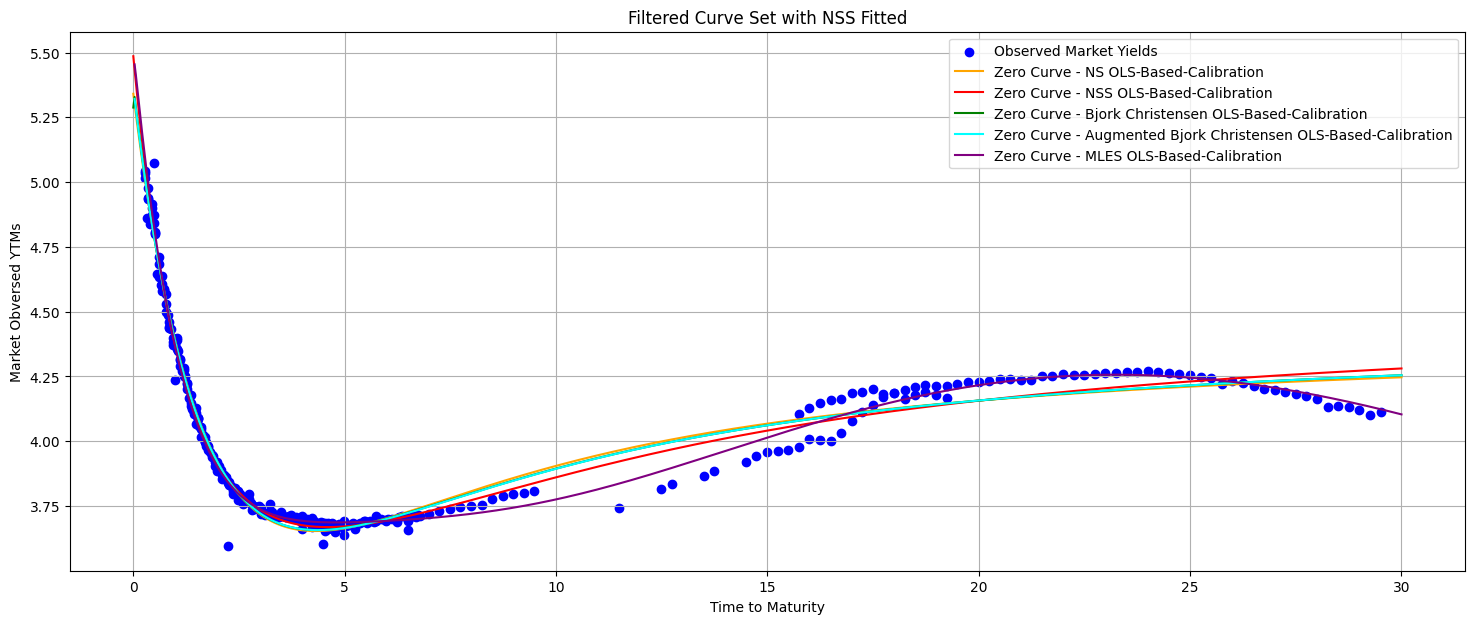

In [7]:
plt.figure(figsize=(18, 7))
plt.scatter(
    filtered_curve_set_df["time_to_maturity"],
    filtered_curve_set_df[f"{quote_type}_yield"],
    color="blue",
    label="Observed Market Yields",
)

t2 = np.linspace(0, 30, 1000)

filtered_curve_set_ns_func, status_ns = calibrate_ns_ols(
    filtered_curve_set_df["time_to_maturity"].to_numpy(),
    filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
)
plt.plot(t2, filtered_curve_set_ns_func(t2), color="orange", label="Zero Curve - NS OLS-Based-Calibration")

filtered_curve_set_nss_func, status_nss, _ = calibrate_nss_ols(
    filtered_curve_set_df["time_to_maturity"].to_numpy(),
    filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
)
plt.plot(t2, filtered_curve_set_nss_func(t2), color="red", label="Zero Curve - NSS OLS-Based-Calibration")

filtered_curve_set_bc_func, status_bc = calibrate_bc_ols(
    filtered_curve_set_df["time_to_maturity"].to_numpy(),
    filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
)
plt.plot(t2, filtered_curve_set_bc_func(t2), color="green", label="Zero Curve - Bjork Christensen OLS-Based-Calibration")

filtered_curve_set_aug_bc_func, status_aug_bc = calibrate_bc_augmented_ols(
    np.concatenate((np.array([1/365]), filtered_curve_set_df["time_to_maturity"].to_numpy())),
    np.concatenate((np.array([5.31]), filtered_curve_set_df[f"{quote_type}_yield"].to_numpy())),
)
plt.plot(t2, filtered_curve_set_aug_bc_func(t2), color="cyan", label="Zero Curve - Augmented Bjork Christensen OLS-Based-Calibration")

filtered_curve_set_mles_func, status_mles = calibrate_mles_ols(
    filtered_curve_set_df["time_to_maturity"].to_numpy(),
    filtered_curve_set_df[f"{quote_type}_yield"].to_numpy(),
    overnight_rate=5.31,
    N=6
)
plt.plot(t2, filtered_curve_set_mles_func(t2), color="purple", label="Zero Curve - MLES OLS-Based-Calibration")

plt.xlabel("Time to Maturity")
plt.ylabel("Market Obversed YTMs")
plt.title("Filtered Curve Set with NSS Fitted")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def par_bond_equation(c, maturity, zero_curve_func):
    discounted_cash_flows = sum(
        (c / 2) * np.exp(-(zero_curve_func(t) / 100) * t)
        for t in np.arange(0.5, maturity + 0.5, 0.5)
    )
    final_payment = 100 * np.exp(-(zero_curve_func(maturity) / 100) * maturity)
    return discounted_cash_flows + final_payment - 100

In [9]:
def par_curve_func(tenor, zero_curve_func):
    init_guess = 4
    return newton(par_bond_equation, x0=init_guess, args=(tenor, zero_curve_func))

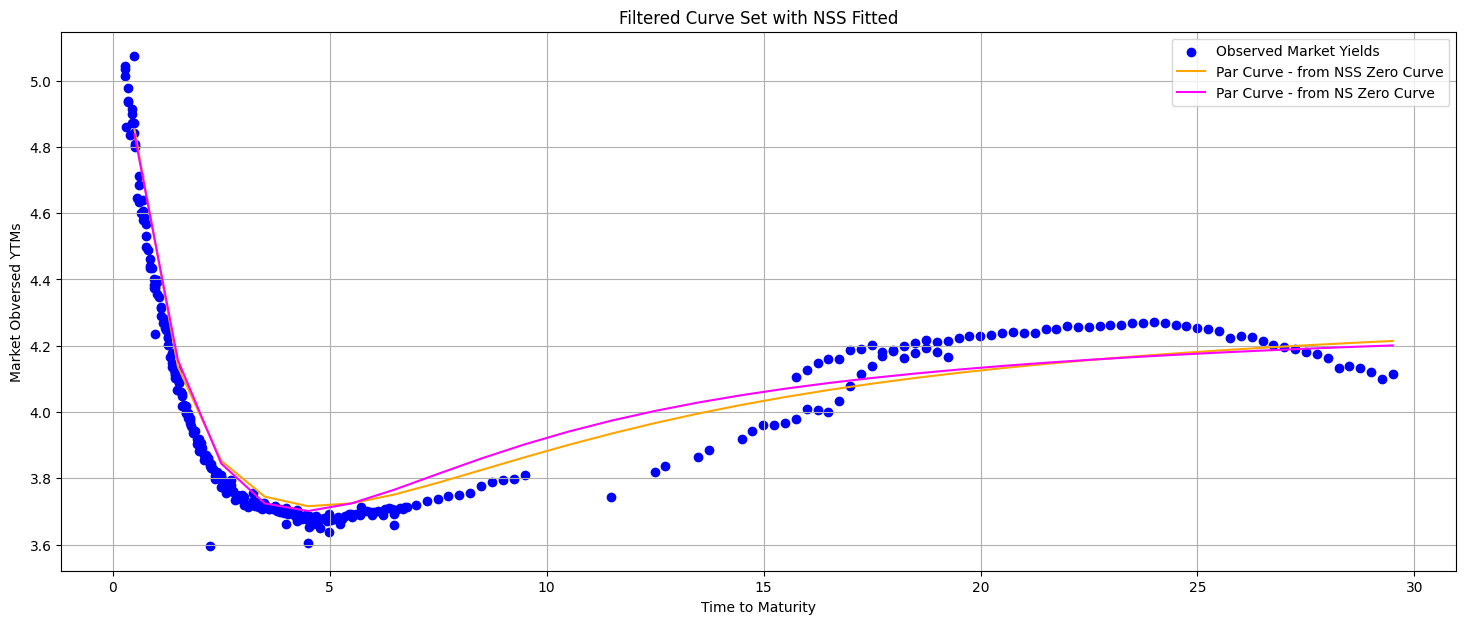

In [10]:
plt.figure(figsize=(18, 7))
plt.scatter(
    filtered_curve_set_df["time_to_maturity"],
    filtered_curve_set_df[f"{quote_type}_yield"],
    color="blue",
    label="Observed Market Yields",
)

t2 = np.arange(0.5, 30, 1)
plt.plot(t2, [par_curve_func(t, filtered_curve_set_nss_func) for t in t2], color="orange", label="Par Curve - from NSS Zero Curve")
plt.plot(t2, [par_curve_func(t, filtered_curve_set_ns_func) for t in t2], color="magenta", label="Par Curve - from NS Zero Curve")

plt.xlabel("Time to Maturity")
plt.ylabel("Market Obversed YTMs")
plt.title("Filtered Curve Set with NSS Fitted")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
display(par_curve_func(30, filtered_curve_set_nss_func))
filtered_curve_set_nss_func(30)

4.217285727087439

4.280847546980537